# Import necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.util import ngrams
from collections import Counter

# 1. Loading the Data

In [3]:
data = pd.read_csv('../data/raw/filtered.tsv', sep='\t')
data.head()

,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


In [ ]:
data.tail()

,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
577772,577772,You didn't know that Estelle had stolen some f...,you didn't know that Estelle stole your fish f...,0.870322,0.030769,0.000121,0.949143
577773,577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.722897,0.058824,0.996124,0.215794
577774,577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.617511,0.212121,0.984538,0.000049
577775,577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.679613,0.358209,0.991945,0.000124
577776,577776,I did not screw him.,I didn't fuck him.,0.868475,0.095238,0.009480,0.994174


**Observation 1:** by looking at the 2 tables above, we can notice that some times the reference text has high toxicity and the translation text has low toxicity and vice virsa. So for training the model it is best to have sample with high toxicity level and its paraphrazed version with low toxicity level instead of mixing them up.

# 2. Basic Statistics

In [ ]:
print(data.shape)
data.describe()

(577777, 7)


,Unnamed: 0,similarity,lenght_diff,ref_tox,trn_tox
count,577777.000000,577777.000000,577777.000000,577777.000000,577777.000000
mean,288888.000000,0.758469,0.157652,0.541372,0.434490
std,166789.997578,0.092695,0.108057,0.457571,0.458904
min,0.000000,0.600001,0.000000,0.000033,0.000033
25%,144444.000000,0.681105,0.066667,0.012171,0.000707
50%,288888.000000,0.754439,0.141791,0.806795,0.085133
75%,433332.000000,0.831244,0.238095,0.990469,0.973739
max,577776.000000,0.950000,0.400000,0.999724,0.999730


**Conclusions:**
1. The dataset comprises 577,777 records.
2. The records, on average, have a moderately high similarity score of approximately 0.7585.
3. The mean length difference between the two compared entities (possibly texts) in the dataset is 0.1577.
4. The reference texts, on average, have a higher toxicity score (0.5414) compared to the transformed/translated texts (0.4345).
5. The median toxicity score of the transformed/translated texts is significantly lower than that of the reference texts, suggesting that, at least for 50% of the records, the transformation/translation resulted in less toxic texts.
6. There is a considerable spread in toxicity scores for both reference and transformed/translated texts, indicating a variety of toxicity levels across the dataset.

## Toxicity Distribution:

C:\Users\Electronica\AppData\Local\Temp\ipykernel_10908\3378070931.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['ref_tox'], color='blue', bins=30, kde=False)
C:\Users\Electronica\AppData\Local\Temp\ipykernel_10908\3378070931.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['t

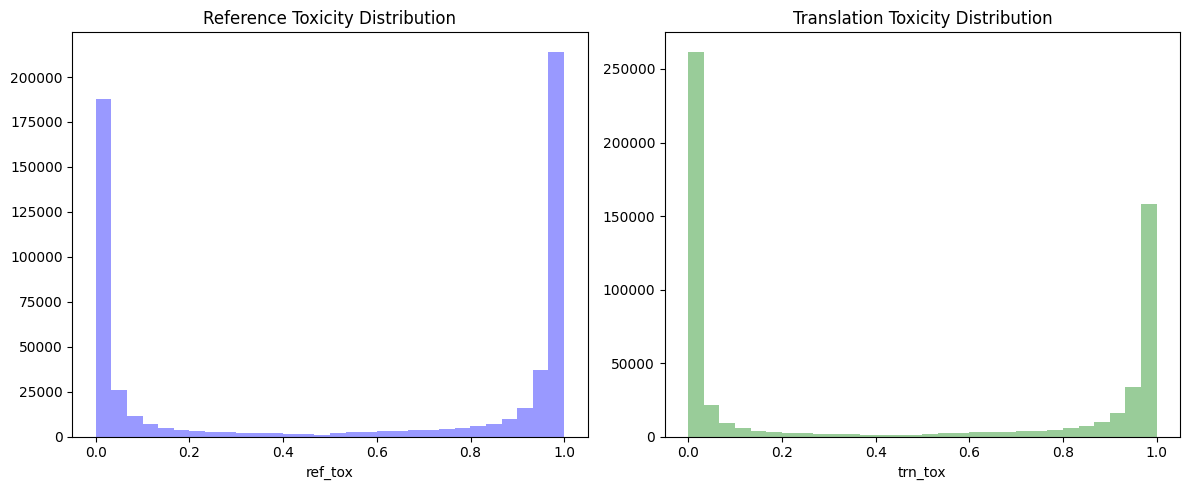

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.distplot(data['ref_tox'], color='blue', bins=30, kde=False)
plt.title('Reference Toxicity Distribution')

plt.subplot(1, 2, 2)
sns.distplot(data['trn_tox'], color='green', bins=30, kde=False)
plt.title('Translation Toxicity Distribution')
plt.tight_layout()
plt.show()


**Conclusions:**

Reference Data (ref_tox):

- Most of the reference data has toxicity scores close to 0.8, suggesting that the original set of data/texts tends to have a higher average toxicity.
- There are relatively fewer instances with low or very high toxicity scores.

Translation Data (trn_tox):

- The translated texts either tend to be not toxic at all (scores close to 0) or highly toxic (scores close to 1).
- There's a relative lack of moderately toxic translations.

Comparison:

- While the reference data tends to cluster around a higher toxicity score (around 0.8), the translations exhibit a more pronounced binary behavior: they are either mostly non-toxic or very toxic.
- This might suggest that whatever translation or transformation process was applied either effectively reduced toxicity in many cases (leading to scores close to 0) or inadvertently introduced high toxicity in others (leading to scores close to 1).


## Similarity and Length Difference Analysis:

C:\Users\Electronica\AppData\Local\Temp\ipykernel_10908\1361921518.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['similarity'], bins=30)
C:\Users\Electronica\AppData\Local\Temp\ipykernel_10908\1361921518.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['lenght_diff'], bins=30)

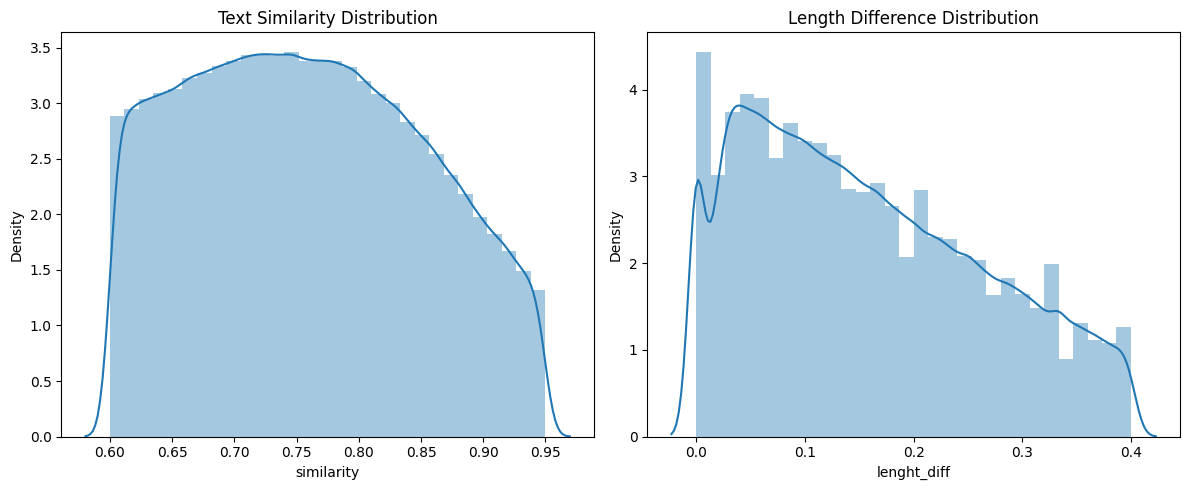

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.distplot(data['similarity'], bins=30)
plt.title('Text Similarity Distribution')

plt.subplot(1, 2, 2)
sns.distplot(data['lenght_diff'], bins=30)
plt.title('Length Difference Distribution')
plt.tight_layout()
plt.show()


**Conclusion**

The majority of the texts are both similar in content (as per the similarity distribution) and length. However, there are notable exceptions where texts differ both in terms of content and length, as seen in the outliers of the distributions.

## Missing Data Check:

In [ ]:
print(data.isnull().sum())


Unnamed: 0            0
reference             0
translation           0
similarity            0
lenght_diff           0
ref_tox               0
trn_tox               0
reference_length      0
translation_length    0
ref_tox_bin           0
dtype: int64


There is no missing data, which is nice

## Outliers check

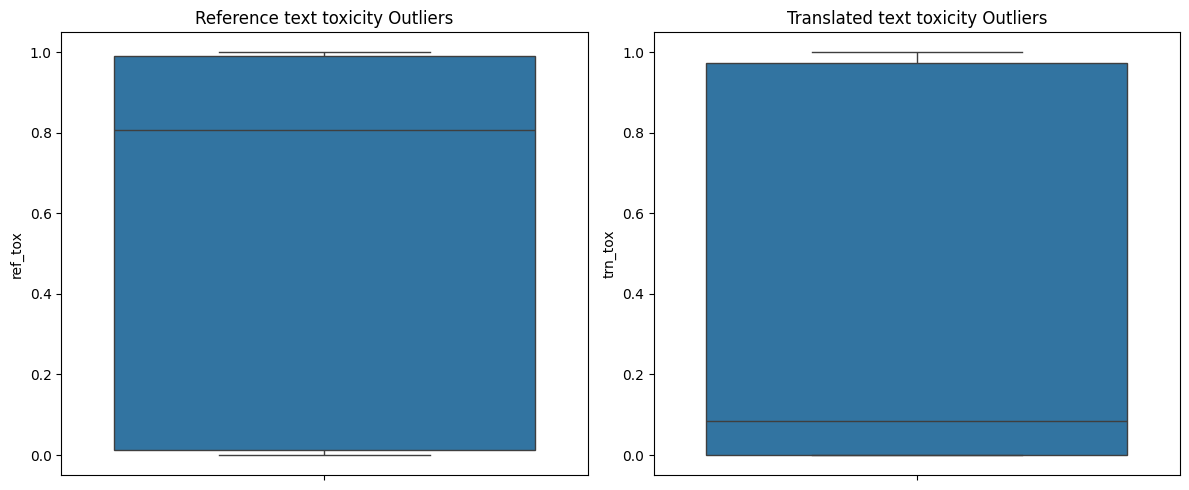

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data['ref_tox'])
plt.title('Reference text toxicity Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(data['trn_tox'])
plt.title('Translated text toxicity Outliers')
plt.tight_layout()
plt.show()


**Conclusion:**
Based on the graphs, there don't appear to be any "outliers" in the traditional sense of data points that fall significantly outside the main distribution of data. Instead, both the "ref_tox" and "trn_tox" have a consistent block of data at a high toxicity level (around 0.8 to 1.0).

## Word count

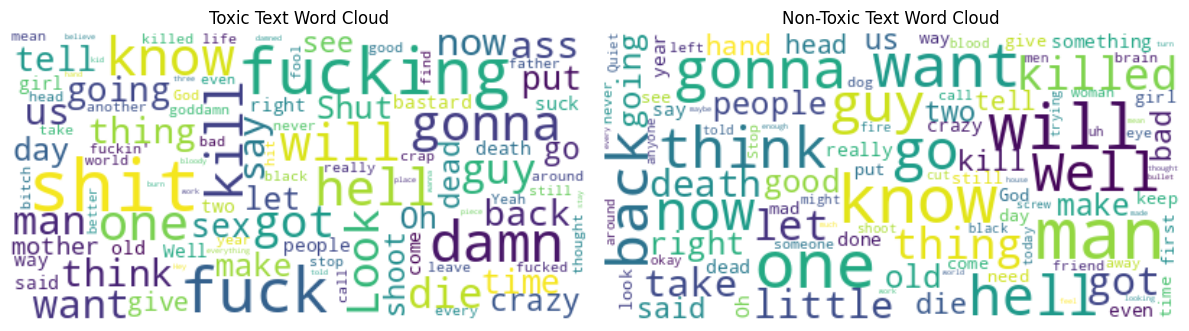

In [6]:
toxic_text = ' '.join(data[data['ref_tox'] > 0.7]['reference'].sample(1000))
non_toxic_text = ' '.join(data[data['ref_tox'] <= 0.3]['reference'].sample(1000))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(toxic_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Toxic Text Word Cloud')

plt.subplot(1, 2, 2)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(non_toxic_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Non-Toxic Text Word Cloud')
plt.tight_layout()
plt.show()


**Conclusions**

From the "Toxic Text Word Cloud":

- Words like "fck", "sht", "damn", "b*tch", and other potentially offensive terms are prominently displayed, indicating they are frequently used in the toxic text dataset.
- Some neutral or less offensive words also appear, possibly due to the context in which they are used or because they are paired with other toxic words.

From the "Non-Toxic Text Word Cloud":

- There are several words, like "know", "think", "want", "well", "man", and "one", which appear in both toxic and non-toxic word clouds. This suggests that these words by themselves don't determine toxicity but rather the context in which they are used matters.

- Some words that can be perceived as negative or potentially offensive, like "killed", "die", "blood", also appear in the non-toxic word cloud. Again, this underlines the importance of context in determining toxicity.

Overall, the word clouds demonstrate the complexity of text analysis, especially when trying to determine the sentiment or toxicity of a given text. The presence of a word in isolation does not necessarily define the sentiment of a sentence or paragraph; the surrounding context plays a significant role.